# Start

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
pkmn = pd.read_csv('Pokemon_with_correct_pkmn_numbers.csv')
pkmn.rename(columns=({'#':'Number', 'Total':'Total Stats'}), inplace=True)
# This way the index starts at 1 and we can correctly join pkmn and combats tables later
pkmn.index = pkmn.index + 1

combats = pd.read_csv("./pokemon_data/combats.csv")

In [3]:
# Note that while Number is not unique, as pokemon like Venusaur and Mega Venusaur both have Number 3, their row index is unique.  This is important bc our combats data keeps track of winners using a pokemon's row index, NOT its pokemon number.  
pkmn.head()

,Number,Name,Type 1,Type 2,Total Stats,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
1,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
2,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
3,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
4,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
5,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [4]:
print(F"The pkmn df has row index starting at {pkmn.index.min()} and ending at {pkmn.index.max()}")
print(F"While the min pkmn.Number is {pkmn.Number.min()} and the max pkmn.Number is {pkmn.Number.max()}")

The pkmn df has row index starting at 1 and ending at 800
While the min pkmn.Number is 1 and the max pkmn.Number is 721


In [5]:
combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [6]:
# Looking at our combats data, our max number for Winner is 800.  This is because a winning pokemon is identified by the row index in the pkmn df.  Winner DOES NOT correspond to pkmn Number.
combats['Winner'].describe()

count    50000.000000
mean       408.890100
std        231.159961
min          1.000000
25%        206.000000
50%        422.000000
75%        606.000000
max        800.000000
Name: Winner, dtype: float64

# Joins

## Identify names of pokemon in winning battles

In [7]:
# Join combats to pkmn table using the row indices (1, 800) for the pkmn table.  This ensures that a pokemon like Venusaur vs. Mega Venusaur will each have their own appropriate number of wins. 
combats_join = pd.merge(combats, pkmn[['Name']], left_on='Winner', right_index=True, how='left')
combats_join.rename(columns={'Name':"winner_name"}, inplace=True)
combats_join.head()

,First_pokemon,Second_pokemon,Winner,winner_name
0,266,298,298,Nuzleaf
1,702,701,701,Terrakion
2,191,668,668,Beheeyem
3,237,683,683,Druddigon
4,151,231,151,Omastar


In [8]:
# Check to see if join was done correctly




## Identifying number of wins for each pokemon from battles data

In [9]:
# Because we may have pokemon that weren't used in combat and we have no data on, we need to use a left join to preserve all 800 unique Pokemon from pkmn table after the join.  Any Pokemon that aren't found in the right df (winners) will get a NaN value.
winners = combats_join['Winner'].value_counts()
pkmn_join = pd.merge(pkmn, winners, how='left', left_index=True, right_index=True)
pkmn_join.rename(mapper={'Winner':'Wins'}, axis=1, inplace=True)
# If a pokemon has NaN for Wins, we have no data on combats for the pokemon and can be considered as having 0 wins.
pkmn_join['Wins'].fillna(value=0, inplace=True)
pkmn_join.sort_values('Wins', ascending=False)

,Number,Name,Type 1,Type 2,Total Stats,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Wins
163,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True,152.0
154,142,Aerodactyl,Rock,Flying,515,80,105,65,60,75,130,1,False,136.0
438,392,Infernape,Fire,Fighting,534,76,104,71,104,71,108,4,False,136.0
428,385,Jirachi,Steel,Psychic,600,100,100,100,100,100,100,3,True,134.0
314,289,Slaking,Normal,NaN,670,150,160,100,95,65,100,3,False,133.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,556,Maractus,Grass,NaN,461,75,86,67,106,67,60,5,False,0.0
183,168,Ariados,Bug,Poison,390,70,90,70,60,60,40,2,False,0.0
322,297,Hariyama,Fighting,NaN,474,144,120,60,40,60,50,3,False,0.0
66,60,Poliwag,Water,NaN,300,40,50,40,40,40,90,1,False,0.0


In [10]:
# Check to see if join was done correctly
num_combats = len(combats)
total_wins = pkmn_join['Wins'].sum()

print(num_combats == total_wins)

True


# kNN classification - Predicting legendary status from pokemon stats (HP, Defense, ..., num_wins_in_combat)

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [12]:
pkmn_join_copy = pkmn_join.copy(deep=True)

numeric_cols_labels = ['Total Stats', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Wins']

numeric_cols = pkmn_join_copy.loc[:, numeric_cols_labels]

## Scale and transform the data

In [13]:
# kNN classification compares Euclidean distance between points when creating the model.  Some of our numeric values are on a larger scale than others, which will have an impact on Euclidean distance, and may disproportionately favor certain columns in the model as a result.  To overcome this issue, we transform our numeric data so all columns are on the same scale.
scaler = StandardScaler()
scaler.fit(numeric_cols)
pkmn_join_copy.loc[:, numeric_cols_labels] = scaler.transform(numeric_cols)

# kNN classification requires quantitative values as input.  For categorical data, we can convert to dummy variables, which are quantitative, and allow for the use of categorical data in the model. 
# Note, we exclude the "Generation" column.  I don't think it's reasonable to know what generation a pokemon comes from when trying to classify it as legendary.
categorical_cols = pkmn_join_copy.loc[:, ['Type 1', 'Type 2']]
categorical_cols_labels = list(categorical_cols.columns)
scaled_with_dummies = pd.get_dummies(pkmn_join_copy.drop(['Number', 'Name', 'Legendary'], axis=1), columns=categorical_cols_labels)

# Lastly, we separate our target labels from the rest of the dataset
target_df = pkmn_join_copy['Legendary']

In [14]:
scaled_with_dummies.head()

,Total Stats,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Wins,Type 1_Bug,...,Type 2_Ghost,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_Normal,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water
1,-0.976765,-0.950626,-0.924906,-0.797154,-0.239130,-0.248189,-0.801503,1,-0.753747,0,...,0,0,0,0,0,1,0,0,0,0
2,-0.251088,-0.362822,-0.524130,-0.347917,0.219560,0.291156,-0.285015,1,-0.487719,0,...,0,0,0,0,0,1,0,0,0,0
3,0.749845,0.420917,0.092448,0.293849,0.831146,1.010283,0.403635,1,0.783306,0,...,0,0,0,0,0,1,0,0,0,0
4,1.583957,0.420917,0.647369,1.577381,1.503891,1.729409,0.403635,1,0.221690,0,...,0,0,0,0,0,1,0,0,0,0
5,-1.051836,-1.185748,-0.832419,-0.989683,-0.392027,-0.787533,-0.112853,1,-0.221690,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
scaled_with_dummies.columns

Index(['Total Stats', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed',
       'Generation', 'Wins', 'Type 1_Bug', 'Type 1_Dark', 'Type 1_Dragon',
       'Type 1_Electric', 'Type 1_Fairy', 'Type 1_Fighting', 'Type 1_Fire',
       'Type 1_Flying', 'Type 1_Ghost', 'Type 1_Grass', 'Type 1_Ground',
       'Type 1_Ice', 'Type 1_Normal', 'Type 1_Poison', 'Type 1_Psychic',
       'Type 1_Rock', 'Type 1_Steel', 'Type 1_Water', 'Type 2_Bug',
       'Type 2_Dark', 'Type 2_Dragon', 'Type 2_Electric', 'Type 2_Fairy',
       'Type 2_Fighting', 'Type 2_Fire', 'Type 2_Flying', 'Type 2_Ghost',
       'Type 2_Grass', 'Type 2_Ground', 'Type 2_Ice', 'Type 2_Normal',
       'Type 2_Poison', 'Type 2_Psychic', 'Type 2_Rock', 'Type 2_Steel',
       'Type 2_Water'],
      dtype='object')

## Which numerical features are most highly correlated with a pokemon being legendary?

In [16]:
pkmn_corr = pkmn_join_copy.corr()

<AxesSubplot:>

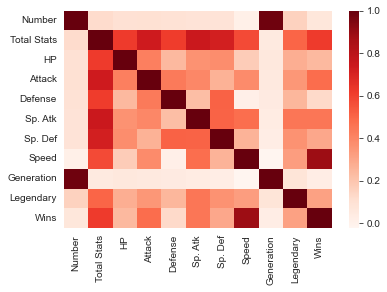

In [17]:
sns.heatmap(pkmn_corr, cmap='Reds')

In [18]:
# Legendary seems most highly correlated with Total Stats, Sp. Atk, Sp. Def, Attack, Speed, and Wins
pkmn_corr['Legendary'].sort_values(ascending=False)

Legendary      1.000000
Total Stats    0.501758
Sp. Atk        0.448907
Sp. Def        0.363937
Attack         0.345408
Speed          0.326715
Wins           0.312999
HP             0.273620
Defense        0.246377
Number         0.153396
Generation     0.079794
Name: Legendary, dtype: float64

In [19]:
most_corr_num_features = pkmn_corr['Legendary'].sort_values(ascending=False)[1:7].index.values

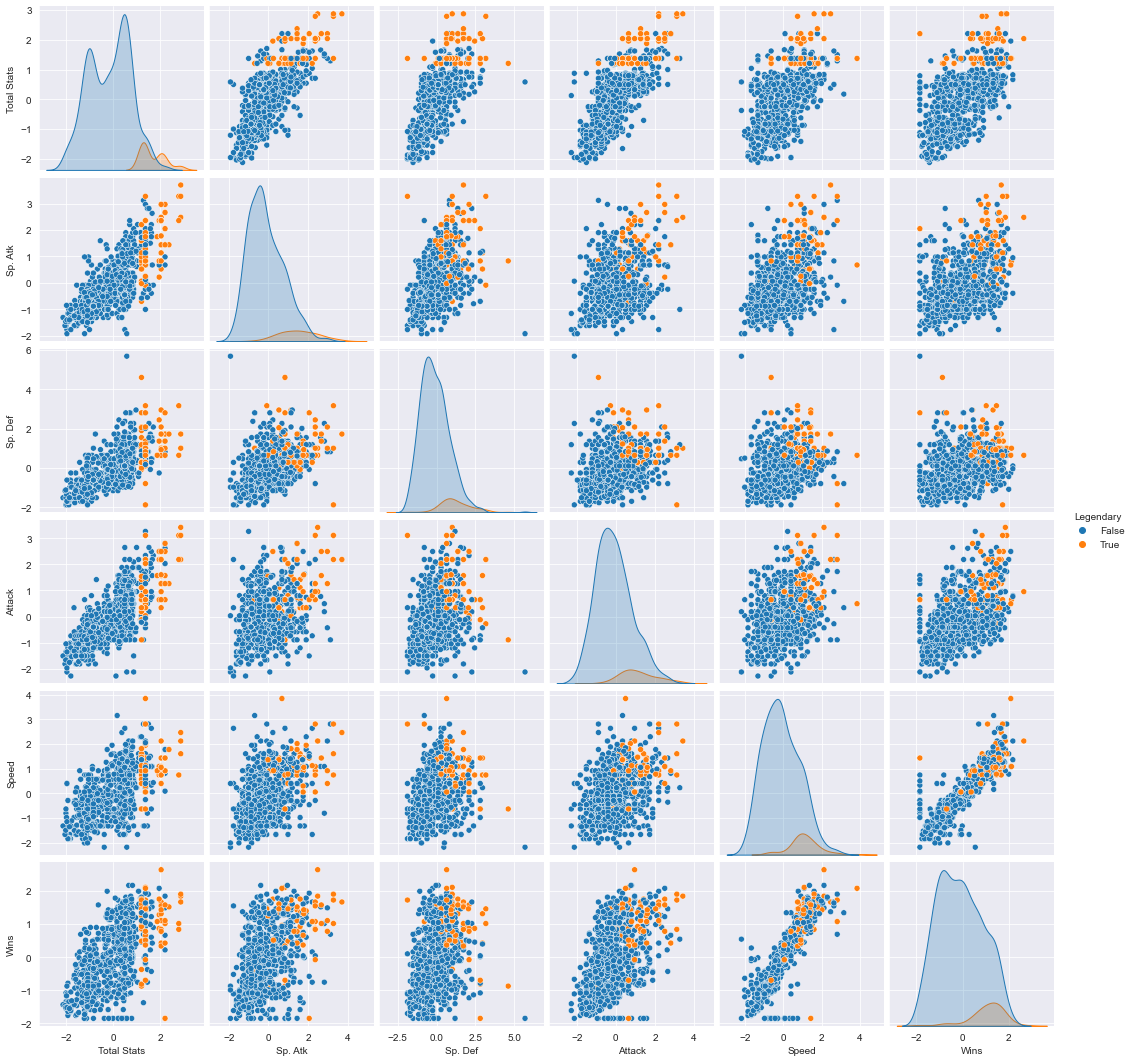

In [20]:
sns.pairplot(pkmn_join_copy[['Total Stats', 'Sp. Atk', 'Sp. Def', 'Attack', 'Speed', 'Wins', 'Legendary']], hue='Legendary')

For most, if not all plots, we see a tendency for Legendary pokemon to cluster in the upper right of each scatter plot, indicating that Legendary pokemon tend to have high stats as compared to non-legendary pokemon.  These features are probably going to be the most important for our model's performance.

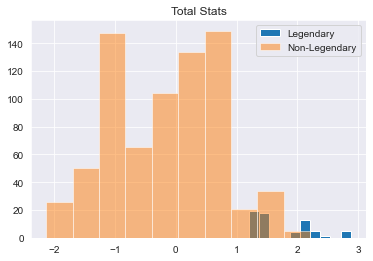

In [21]:
fig, ax = plt.subplots(1,1)
pkmn_join_copy[pkmn_join_copy['Legendary']==True].hist(column='Total Stats', ax=ax)
pkmn_join_copy[pkmn_join_copy['Legendary']==False].hist(column='Total Stats', ax=ax, alpha=0.5)
plt.legend(['Legendary', 'Non-Legendary'])
plt.show();

Focusing on the aggregated total stats, we see legendary pokemon are towards the top.  This feature alone may be sufficient for our model.

## Building Models

### Creating Model using all features except total stats.

First, I'm going to consider building a model that uses each stat.  The extra granularity here may help build a better model, but it will be more complex as a result.  I'll first start using all available features, but then see what happens when I narrow down to focusing on the numerical values that are most highly correlated with legendary: Sp. Atk, Sp. Def, Attack, Speed, and Wins

In [22]:
# Drop Total Stats column as we have more granularity if we look at each stat individually.  We can consider building a model that looks at total stats later on and compare performance to the model we build now.
scaled_with_dummies_no_total = scaled_with_dummies.drop('Total Stats', axis=1)

In [23]:
scaled_with_dummies_no_total.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Wins,Type 1_Bug,Type 1_Dark,...,Type 2_Ghost,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_Normal,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water
1,-0.950626,-0.924906,-0.797154,-0.239130,-0.248189,-0.801503,1,-0.753747,0,0,...,0,0,0,0,0,1,0,0,0,0
2,-0.362822,-0.524130,-0.347917,0.219560,0.291156,-0.285015,1,-0.487719,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.420917,0.092448,0.293849,0.831146,1.010283,0.403635,1,0.783306,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.420917,0.647369,1.577381,1.503891,1.729409,0.403635,1,0.221690,0,0,...,0,0,0,0,0,1,0,0,0,0
5,-1.185748,-0.832419,-0.989683,-0.392027,-0.787533,-0.112853,1,-0.221690,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Which n_neighbors is most optimal and what is the performance?

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
knn_all_features_no_total = KNeighborsClassifier()

param_grid = {'n_neighbors': np.arange(1,101,2)}

knn_all_features_no_total_gscv = GridSearchCV(knn_all_features_no_total, param_grid, cv=5)
knn_all_features_no_total_gscv.fit(scaled_with_dummies_no_total, target_df)

print(F"Optimal n_neighbors for model: {knn_all_features_no_total_gscv.best_params_}")
print(F"Highest model performance: {knn_all_features_no_total_gscv.best_score_}")

Optimal n_neighbors for model: {'n_neighbors': 19}
Highest model performance: 0.9362499999999999


This will establish our baseline.  Let's see if we can build a model that is less complex and performs better.

### Creating Model with all features, except HP, Attack, Defense, Sp. Attack, and Sp. Defense are swapped for an aggregate called total_stats.  Our model might not need to know the individual stats to perform well.

In [26]:
stats_labels = numeric_cols_labels[1:]
scaled_with_dummies_total = scaled_with_dummies.drop(stats_labels, axis=1)

#### Which n_neighbors is most optimal and what is the performance?

In [27]:
knn_all_features_with_total = KNeighborsClassifier()

knn_all_features_with_total_gscv = GridSearchCV(knn_all_features_with_total, param_grid, cv=5)
knn_all_features_with_total_gscv.fit(scaled_with_dummies_total, target_df)

print(F"Optimal n_neighbors for model: {knn_all_features_with_total_gscv.best_params_}")
print(F"Highest model performance: {knn_all_features_with_total_gscv.best_score_}")

Optimal n_neighbors for model: {'n_neighbors': 41}
Highest model performance: 0.925


We see worse performance with this model.  It's more complex, with an optimal n_neighbors of 41 and performs slightly worse.

### Creating model that focuses solely on numerical values that were highly correlated with legendary: Total Stats, Sp. Atk, Sp. Def, Attack, Speed, and Wins

#### Model using Sp. Atk, Sp. Def, Attack, Speed, and Wins

In [28]:
individual_stats_and_wins = scaled_with_dummies[['Sp. Atk', 'Sp. Def', 'Attack', 'Speed', 'Wins']]

In [29]:
knn_individual_stats_and_wins = KNeighborsClassifier()

knn_individual_stats_and_wins_gscv = GridSearchCV(knn_individual_stats_and_wins, param_grid, cv=5)
knn_individual_stats_and_wins_gscv.fit(individual_stats_and_wins, target_df)

print(F"Optimal n_neighbors for model: {knn_individual_stats_and_wins_gscv.best_params_}")
print(F"Highest model performance: {knn_individual_stats_and_wins_gscv.best_score_}")

Optimal n_neighbors for model: {'n_neighbors': 15}
Highest model performance: 0.9400000000000001


We're starting to see better performance when we reduce the number of inputs to the model.  Now the optimal n_neighbors is only 15, with slightly better performance than our previous models.

#### Model using only Total Stats and Wins

In [30]:
total_stats_and_wins = scaled_with_dummies[['Total Stats', 'Wins']]

##### Which n_neighbors is most optimal and what is the performance?

In [31]:
knn_total_stats_and_wins = KNeighborsClassifier()

knn_total_stats_and_wins_gscv = GridSearchCV(knn_total_stats_and_wins, param_grid, cv=5)
knn_total_stats_and_wins_gscv.fit(total_stats_and_wins, target_df)

print(F"Optimal n_neighbors for model: {knn_total_stats_and_wins_gscv.best_params_}")
print(F"Highest model performance: {knn_total_stats_and_wins_gscv.best_score_}")

Optimal n_neighbors for model: {'n_neighbors': 3}
Highest model performance: 0.9475000000000001


This model is much less complex, having an optimal n_neighbors of 3, and better performance than our previous models.  It also only requires two input variables.  Using total stats and wins is looking to be our best model so far.

#### Model using only total stats

In [32]:
total_stats = scaled_with_dummies.loc[:,'Total Stats']
total_stats = np.array(total_stats).reshape(-1,1)

In [33]:
knn_total_stats = KNeighborsClassifier()

knn_total_stats_gscv = GridSearchCV(knn_total_stats, param_grid, cv=5)
knn_total_stats_gscv.fit(total_stats, target_df)

print(F"Optimal n_neighbors for model: {knn_total_stats_gscv.best_params_}")
print(F"Highest model performance: {knn_total_stats_gscv.best_score_}")

Optimal n_neighbors for model: {'n_neighbors': 5}
Highest model performance: 0.9575000000000001


Slightly better performance, with a slightly more complex n_neighbors of 5, but now we only have one input variable.  Using total stats, or total stats and wins, both seem like reasonable choices for our final model.  Let's investigate their performance a little further.

## Further investigating performance of our two top models

### Model: Total stats and wins

In [34]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(total_stats_and_wins, target_df, test_size=0.2, random_state=5)

In [ ]:
knn_total_stats_and_wins.set_params(n_neighbors=3)
knn_total_stats_and_wins.fit(X_train, y_train)
y_preds = knn_total_stats_and_wins.predict(X_test)
confusion_matrix(y_test, y_preds)

In [ ]:
knn_total_stats_and_wins_score = knn_total_stats_and_wins.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds, pos_label=None, average='weighted')
precision = precision_score(y_test, y_preds, pos_label=None, average='weighted')
recall = recall_score(y_test, y_preds, pos_label=None, average='weighted')

In [ ]:
knn_total_stats_and_wins_score, accuracy, f1, precision, recall

In [ ]:
print(classification_report(y_test, y_preds))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_preds, cmap='Greens', display_labels=['Non-Legendary', 'Legendary'], colorbar=False);

Decent performance, but let's see how our other top model performs.

### Model: Total stats

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(total_stats, target_df, test_size=0.2, random_state=6)

In [ ]:
knn_total_stats.set_params(n_neighbors=5)
knn_total_stats.fit(X_train, y_train)
y_preds = knn_total_stats.predict(X_test)
confusion_matrix(y_test, y_preds)

In [ ]:
knn_total_stats_score = knn_total_stats.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds, pos_label=None, average='weighted')
precision = precision_score(y_test, y_preds, pos_label=None, average='weighted')
recall = recall_score(y_test, y_preds, pos_label=None, average='weighted')

In [ ]:
knn_total_stats_score, accuracy, f1, precision, recall

In [ ]:
print(classification_report(y_test, y_preds))

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_preds, cmap='Greens', display_labels=['Non-Legendary', 'Legendary'], colorbar=False);

This model looks to perform quite well.  it has ~96% for accuracy, f1, precision, and recall, using only one input.  

# Logistic Regression - Predicting Legendary Status

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_with_dummies, target_df, test_size=0.4)
lr = LogisticRegression().fit(X_train, y_train)
lr.score(X_test, y_test)

In [ ]:
plot_confusion_matrix(lr, X_test, y_test, cmap=plt.cm.Blues)

In [ ]:
lr_preds = lr.predict(X_test)
print(classification_report(y_test, lr_preds))

In [ ]:
pkmn_join.corr()

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(pkmn_join.corr(), cmap=plt.get_cmap('gist_gray'))

Based on the correlation df and heatmap above, Legendary is most highly correlated with the following 3 quantitative variables:
    1. Total
    2. Sp. Atk
    3. Sp. Def
As total is the sum of all of the other stats, HP, Attack, Defense, Sp. Atk, Sp. Def, and Speed, I'd expect it to be collinear with the other variables.  Let's check:

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
pkmn_copy = pkmn_join.copy(deep=True)
pkmn_copy['Legendary'] = pkmn_copy['Legendary'].astype('int')

In [ ]:
variance_inflation_factor(pkmn_copy.loc[:,['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Legendary']].values, 6)

In [ ]:
pkmn_copy.loc[:,['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Legendary']]

In [ ]:
X

In [ ]:
def calc_vif(X):
    """
    X: A pandas DataFrame object of numerical independent variables to be used in regression,
    Calculates the variance inflation factor of each independent variable in X
    against all of the other independent variables in X"""
    vif = pd.DataFrame()
    vif['Variables'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return(vif)

In [ ]:
new_df = pkmn_copy.loc[:,['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Legendary']]
X = new_df.iloc[:,:-1]
calc_vif(X)

In [ ]:
new_df = pkmn_copy.loc[:,['HP', 'Attack', 'Defense', 'Sp. Atk', 'Speed', 'Legendary']]
X = new_df.iloc[:,:-1]
calc_vif(X)

In [ ]:
new_df = pkmn_copy.loc[:,['HP', 'Defense', 'Sp. Atk', 'Speed', 'Legendary']]
X = new_df.iloc[:,:-1]
calc_vif(X)

In [ ]:
new_df = pkmn_copy.loc[:,['Defense', 'Sp. Atk', 'Speed', 'Legendary']]
X = new_df.iloc[:,:-1]
calc_vif(X)

In [ ]:
new_df = pkmn_copy.loc[:,['Defense', 'Speed', 'Legendary']]
X = new_df.iloc[:,:-1]
calc_vif(X)

In [ ]:
#scaled_with_dummies
new_df = scaled_with_dummies.loc[:,['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
X = new_df.iloc[:,:]
calc_vif(X)

In [ ]:
lr = LogisticRegression(random_state=4)
lr.fit(pkmn_join.loc[:,['Defense', 'Speed']], target_df)
lr.coef_

In [ ]:
lr = LogisticRegression(random_state=4)
lr.fit(scaled_with_dummies.loc[:,['Defense', 'Speed']], target_df)
lr.coef_

## Regression

In [ ]:
pkmn_join.plot.scatter('Total', 'Wins')

In [ ]:
pkmn_join.Wins

In [ ]:
pkmn_join['Wins']